In [1]:
import os
import time
import random
import numpy as np
import pandas as pd
import tensorflow as tf

from IPython.display import clear_output
import matplotlib.pyplot as plt
import seaborn as sns
import cv2
import plotly.express as px

from tensorflow.keras.preprocessing.image import ImageDataGenerator  # docs: flow_from_directory() + rescale/augment
from tensorflow.keras import Sequential
from tensorflow.keras.layers import (Conv2D, MaxPooling2D, BatchNormalization,
                                     Dropout, Dense, GlobalAveragePooling2D)
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from sklearn.metrics import classification_report, confusion_matrix

# (як у прикладі) інсталятор для розділення на train/val/test
!pip -q install split-folders
import splitfolders

# Фіксуємо сід, аби відтворюваність була стабільнішою
SEED = 123
random.seed(SEED)
np.random.seed(SEED)
tf.random.set_seed(SEED)

print("TensorFlow:", tf.__version__)
print("GPU available:", tf.config.list_physical_devices('GPU'))

TensorFlow: 2.20.0
GPU available: []


### Load the [dataset](https://www.kaggle.com/datasets/parnianmalekian/rice-image-classification?resource=download)

### EDA


Класи: ['Arborio', 'Basmati', 'Ipsala', 'Jasmine', 'Karacadag']
К-сть зображень по класах: [15000, 15000, 15000, 15000, 15000]


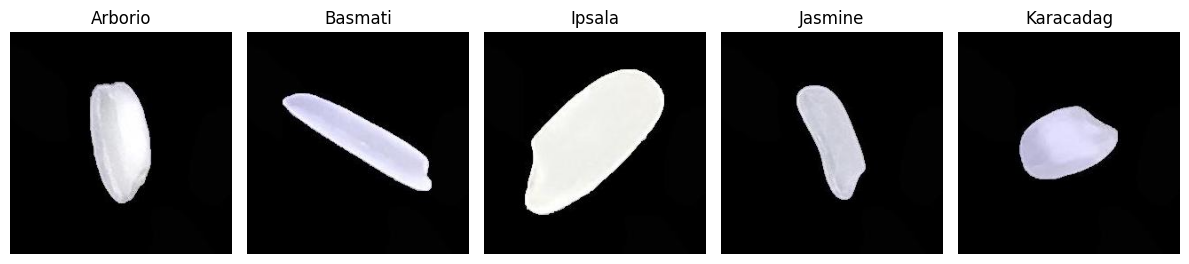

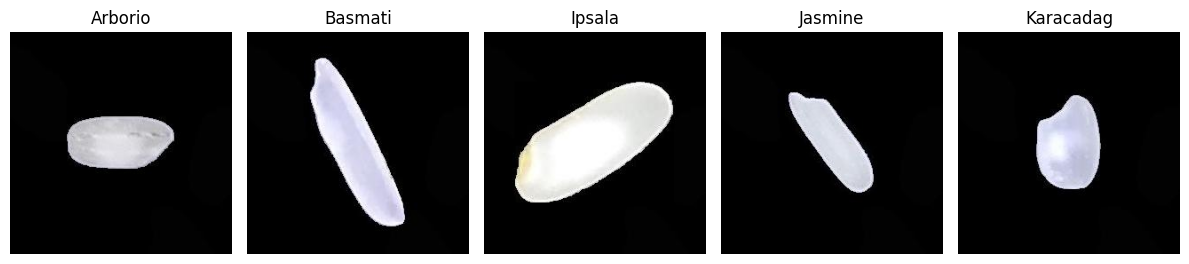

In [ ]:
rootPath = '../data/Rice_Image_Dataset'

class_names = sorted([d for d in os.listdir(rootPath) if os.path.isdir(os.path.join(rootPath, d))])
print("Класи:", class_names)

sizes = [len(os.listdir(os.path.join(rootPath, name))) for name in class_names]
print("К-сть зображень по класах:", sizes)

fig = px.pie(
    names=class_names,
    values=sizes,
    width=500,
    title='Розподіл класів (Rice Image Dataset)',
    hole=0.4
)
fig.update_layout({'title': {'x': 0.5}})
fig.show()

# Допоміжна візуалізація випадкових зображень
def load_random_img(dir_path, labels, n_cols=5):
    plt.figure(figsize=(12, 6))
    for i, label in enumerate(labels[:n_cols], 1):
        file = random.choice(os.listdir(os.path.join(dir_path, label)))
        image_path = os.path.join(dir_path, label, file)
        img = cv2.imread(image_path)[:, :, ::-1]  # BGR->RGB
        plt.subplot(1, n_cols, i)
        plt.title(label)
        plt.imshow(img)
        plt.axis('off')
    plt.tight_layout()

for _ in range(2):
    load_random_img(rootPath, class_names)

### Розбиття на train/val/test

In [4]:
out_dir = "../data/rice_imgs"
if not os.path.exists(out_dir) or not os.path.isdir(os.path.join(out_dir, "train")):
    splitfolders.ratio(rootPath, output=out_dir, seed=SEED, ratio=(.7, .15, .15), group_prefix=None)

batch_size = 128
img_height, img_width = 256, 256
input_shape = (img_height, img_width, 3)

### Генератори даних

In [5]:
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=10,
    width_shift_range=0.05,
    height_shift_range=0.05,
    zoom_range=0.1,
    horizontal_flip=True
)
test_datagen = ImageDataGenerator(rescale=1./255)

Train = train_datagen.flow_from_directory(
    os.path.join(out_dir, 'train'),
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=True,
    seed=SEED
)

Val = test_datagen.flow_from_directory(
    os.path.join(out_dir, 'val'),
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=False
)

Test = test_datagen.flow_from_directory(
    os.path.join(out_dir, 'test'),
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=False
)

print("Індекси класів:", Train.class_indices)

Found 52500 images belonging to 5 classes.
Found 11250 images belonging to 5 classes.
Found 11250 images belonging to 5 classes.
Індекси класів: {'Arborio': 0, 'Basmati': 1, 'Ipsala': 2, 'Jasmine': 3, 'Karacadag': 4}


### CNN

In [6]:
def build_cnn(input_shape=(256, 256, 3), n_classes=5):
    model = Sequential()

    # Block 1
    model.add(Conv2D(32, 3, activation='relu', padding='same', input_shape=input_shape))
    model.add(MaxPooling2D(2))
    model.add(BatchNormalization())

    # Block 2
    model.add(Conv2D(64, 3, activation='relu', padding='same'))
    model.add(MaxPooling2D(2))
    model.add(BatchNormalization())

    # Block 3 (додали порівняно з прикладом)
    model.add(Conv2D(128, 3, activation='relu', padding='same'))
    model.add(MaxPooling2D(2))
    model.add(Dropout(0.30))

    # Замість величезного Flatten — GlobalAveragePooling2D значно зменшує параметри
    model.add(GlobalAveragePooling2D())

    # Класична "повнозв’язна" частина
    model.add(Dense(256, activation='relu'))
    model.add(Dropout(0.40))

    # Вихід на 5 класів з softmax (на відміну від sigmoid у прикладі)
    model.add(Dense(n_classes, activation='softmax'))
    return model

CNN = build_cnn(input_shape=input_shape, n_classes=Train.num_classes)
CNN.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
CNN.summary()

e:\University\4_year_(1_semester)\Технології глибокого навчання\deep_learning_technologies\.venv\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:113: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.



Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 256, 256, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 128, 128, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 128, 128, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 128, 128, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 64, 64, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 64, 64, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 64, 64, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 32, 32, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 32, 32, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 128)            │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 256)            │        33,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 5)              │         1,285 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 127,941 (499.77 KB)

 Trainable params: 127,749 (499.02 KB)

 Non-trainable params: 192 (768.00 B)

### Навчання

In [ ]:
ckpt_path = "best_cnn.keras"

callbacks = [
    EarlyStopping(monitor='val_accuracy', patience=3, restore_best_weights=True),
    ModelCheckpoint(ckpt_path, monitor='val_accuracy', save_best_only=True)
]

EPOCHS = 11
start_time = time.time()
history = CNN.fit(
    Train,
    validation_data=Val,
    epochs=EPOCHS,
    callbacks=callbacks,
    verbose=1
)
train_time_sec = time.time() - start_time
print(f"Час навчання (сек): {train_time_sec:.1f}")

e:\University\4_year_(1_semester)\Технології глибокого навчання\deep_learning_technologies\.venv\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning:

Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.



Epoch 1/11
253/411 ━━━━━━━━━━━━━━━━━━━━ 17:38 7s/step - accuracy: 0.7387 - loss: 0.6480

### Оцінювання

In [ ]:
score = CNN.evaluate(Test, verbose=1)
print(f"Model Loss: {score[0]:.6f}, Accuracy: {score[1]*100:.2f}%")

# Прогнози та метрики
Y_pred = CNN.predict(Test)
y_pred = np.argmax(Y_pred, axis=1)          # індекс класу з макс. ймовірністю
y_true = Test.classes                        # істинні індекси класів
labels = list(Test.class_indices.keys())     # імена класів в тому ж порядку

# Матриця неточностей
cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(6, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=labels, yticklabels=labels,
            linewidths=0.5, linecolor='white')
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix")
plt.tight_layout()
plt.show()

# Звіт класифікації
report = classification_report(y_true, y_pred, target_names=labels, output_dict=True)
df_report = pd.DataFrame(report).transpose()
df_report

### Перевірка на 1 зображенні

In [ ]:
# Приклад: беремо будь-яке реальне зображення з папок тесту класу Basmati.
sample_dir = os.path.join(out_dir, 'test', labels[1])  # наприклад клас з індексом 1
sample_file = random.choice(os.listdir(sample_dir))
sample_path = os.path.join(sample_dir, sample_file)

testImage = tf.keras.utils.load_img(sample_path, target_size=(img_height, img_width))
testImage_arr = tf.keras.utils.img_to_array(testImage)[None, ...] / 255.0
Result = CNN.predict(testImage_arr)
print("Вектор ймовірностей:", np.round(Result[0], 4))
print("Клас:", labels[np.argmax(Result)])

### експерименти

In [ ]:
def build_cnn_variant(experiment='base', input_shape=(256,256,3), n_classes=5):
    m = Sequential()
    if experiment == 'small':
        # трішки менша модель
        m.add(Conv2D(32, 3, activation='relu', padding='same', input_shape=input_shape))
        m.add(MaxPooling2D(2))
        m.add(Conv2D(64, 3, activation='relu', padding='same'))
        m.add(MaxPooling2D(2))
        m.add(GlobalAveragePooling2D())
        m.add(Dense(128, activation='relu'))
        m.add(Dense(n_classes, activation='softmax'))
    elif experiment == 'wider':
        # трішки ширша/глибша модель
        m.add(Conv2D(64, 3, activation='relu', padding='same', input_shape=input_shape))
        m.add(Conv2D(64, 3, activation='relu', padding='same'))
        m.add(MaxPooling2D(2))
        m.add(BatchNormalization())
        m.add(Conv2D(128, 3, activation='relu', padding='same'))
        m.add(Conv2D(128, 3, activation='relu', padding='same'))
        m.add(MaxPooling2D(2))
        m.add(Dropout(0.35))
        m.add(GlobalAveragePooling2D())
        m.add(Dense(256, activation='relu'))
        m.add(Dropout(0.45))
        m.add(Dense(n_classes, activation='softmax'))
    else:
        # 'base' — те, що вище у build_cnn()
        return build_cnn(input_shape, n_classes)
    return m

# Приклад використання:
EXPERIMENT = 'small'  # 'small' | 'base' | 'wider'
CNN = build_cnn_variant(EXPERIMENT, input_shape, Train.num_classes)
CNN.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
CNN.fit(Train, validation_data=Val, epochs=EPOCHS, callbacks=callbacks)
